# Access DART data from NCAR's data origin and benchmark

In [1]:
# Display output of plots directly in Notebook
import intake
import numpy as np
import pandas as pd
import xarray as xr
import re
import aiohttp
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt

In [2]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [3]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [4]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [5]:
# # This overwrites the default scheduler with a single-threaded scheduler
# dask.config.set(scheduler='synchronous')  

In [6]:
# File paths
rda_scratch   = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_url       =  'https://data.rda.ucar.edu/'
database_num  = 'd345001'
cam6_dart_url = rda_url + database_num
#
https_catalog = cam6_dart_url + '/catalogs/https/'+ database_num +'-https-zarr.json'
osdf_catalog  = cam6_dart_url + '/catalogs/osdf/'+ database_num +'-osdf-zarr.json'

### Create a Dask cluster

#### Dask Introduction

Dask is a solution that enables the scaling of Python libraries. It mimics popular scientific libraries such as numpy, pandas, and xarray that enables an easier path to parallel processing without having to refactor code.

There are 3 components to parallel processing with Dask: the client, the scheduler, and the workers.

The Client is best envisioned as the application that sends information to the Dask cluster. In Python applications this is handled when the client is defined with client = Client(CLUSTER_TYPE). A Dask cluster comprises of a single scheduler that manages the execution of tasks on workers. The CLUSTER_TYPE can be defined in a number of different ways.

There is LocalCluster, a cluster running on the same hardware as the application and sharing the available resources, directly in Python with dask.distributed.

In certain JupyterHubs Dask Gateway may be available and a dedicated dask cluster with its own resources can be created dynamically with dask.gateway.

On HPC systems dask_jobqueue is used to connect to the HPC Slurm, PBS or HTCondor job schedulers to provision resources.

The dask.distributed client python module can also be used to connect to existing clusters. A Dask Scheduler and Workers can be deployed in containers, or on Kubernetes, without using a Python function to create a dask cluster. The dask.distributed Client is configured to connect to the scheduler either by container name, or by the Kubernetes service name.

#### Select the Dask cluster type
The default will be LocalCluster as that can run on any system.

If running on a HPC computer with a PBS Scheduler, set to True. Otherwise, set to False.

In [ ]:
USE_PBS_SCHEDULER = True

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [ ]:
USE_DASK_GATEWAY = False

#### Python function for a PBS cluster

In [ ]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = rda_scratch + '/dask/spill',
        log_directory = rda_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

#### Python function for a Gateway Cluster

In [ ]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

#### Python function for a Local Cluster

In [ ]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(4)
    return cluster

#### Python logic to select the Dask Cluster type

This uses True/False boolean logic based on the variables set in the previous cells

In [ ]:
# Obtain dask cluster in one of three ways

if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

In [ ]:
# Scale the cluster and display cluster dashboard URL
# cluster.scale(4)
cluster

## Access the data from NCAR's Research Data Archive using intake

In [10]:
df_https_test = intake.open_esm_datastore(https_catalog)
df_https_test.df['path'].values

array(['https://data.rda.ucar.edu/d345001/hourly6/HR.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/TSA.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/EFLX_LH_TOT.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/ER.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/VS.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/PS.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/Q.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/US.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/CLDICE.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/T.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/CLDLIQ.zarr'],
      dtype=object)

In [11]:
df_osdf_test = intake.open_esm_datastore(osdf_catalog)
df_osdf_test.df['path'].values

array(['osdf:///ncar/rda/d345001/hourly6/HR.zarr',
       'osdf:///ncar/rda/d345001/hourly6/TSA.zarr',
       'osdf:///ncar/rda/d345001/hourly6/EFLX_LH_TOT.zarr',
       'osdf:///ncar/rda/d345001/hourly6/ER.zarr',
       'osdf:///ncar/rda/d345001/weekly/VS.zarr',
       'osdf:///ncar/rda/d345001/weekly/PS.zarr',
       'osdf:///ncar/rda/d345001/weekly/Q.zarr',
       'osdf:///ncar/rda/d345001/weekly/US.zarr',
       'osdf:///ncar/rda/d345001/weekly/CLDICE.zarr',
       'osdf:///ncar/rda/d345001/weekly/T.zarr',
       'osdf:///ncar/rda/d345001/weekly/CLDLIQ.zarr'], dtype=object)

In [12]:
data_var = 'PS'
col_subset_https = df_https_test.search(variable=data_var)
col_subset_osdf  = df_osdf_test.search(variable=data_var)

In [13]:
dsets_https = col_subset_https.to_dataset_dict(zarr_kwargs={"consolidated": True})
#
print(f"\nDataset dictionary keys:\n {dsets_https.keys()}")
# Load the first dataset and display a summary.
dataset_key = list(dsets_https.keys())[0]
#
ds_https = dsets_https[dataset_key]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'



Dataset dictionary keys:
 dict_keys(['PS.weekly.atm.1'])


In [14]:
dsets_osdf  = col_subset_osdf.to_dataset_dict()
ds_osdf     = dsets_osdf[dataset_key]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'


In [15]:
ds_osdf  = ds_osdf.PS
ds_https = ds_https.PS
ds_osdf

<xarray.DataArray 'PS' (member_id: 80, time: 471, lat: 192, lon: 288)> Size: 17GB
dask.array<open_dataset-PS, shape=(80, 471, 192, 288), dtype=float64, chunksize=(80, 80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 640B 1 2 3 4 5 6 7 8 ... 74 75 76 77 78 79 80
  * time       (time) datetime64[ns] 4kB 2011-01-03 2011-01-10 ... 2019-12-30
Attributes:
    long_name:  Surface pressure
    units:      Pa

## Data Access Speed tests
- We will now test how long it takes to access data (via OSDF and https-only prrotocols) for various sizes using the above array

### Prepare data subsets

In [16]:
ds_osdf_1Kb  = ds_osdf.isel(lat=0,lon=0,member_id=0).isel(time=np.arange(130))
ds_https_1Kb = ds_https.isel(lat=0,lon=0,member_id=0).isel(time=np.arange(130))
ds_https_1Kb

<xarray.DataArray 'PS' (time: 130)> Size: 1kB
dask.array<getitem, shape=(130,), dtype=float64, chunksize=(80,), chunktype=numpy.ndarray>
Coordinates:
    lat        float32 4B -90.0
    lon        float32 4B 0.0
    member_id  int64 8B 1
  * time       (time) datetime64[ns] 1kB 2011-01-03 2011-01-10 ... 2013-06-17
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [17]:
ds_osdf_1Mb  = ds_osdf.isel(time=0).isel(member_id =1+ np.arange(3))
ds_https_1Mb = ds_https.isel(time=0).isel(member_id =1+ np.arange(3))
ds_osdf_1Mb

<xarray.DataArray 'PS' (member_id: 3, lat: 192, lon: 288)> Size: 1MB
dask.array<getitem, shape=(3, 192, 288), dtype=float64, chunksize=(3, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 24B 2 3 4
    time       datetime64[ns] 8B 2011-01-03
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [18]:
ds_osdf_10Mb  = ds_osdf.isel(member_id =4).isel(time=np.arange(24))
ds_https_10Mb = ds_https.isel(member_id =4).isel(time=np.arange(24))
ds_osdf_10Mb

<xarray.DataArray 'PS' (time: 24, lat: 192, lon: 288)> Size: 11MB
dask.array<getitem, shape=(24, 192, 288), dtype=float64, chunksize=(24, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  int64 8B 5
  * time       (time) datetime64[ns] 192B 2011-01-03 2011-01-10 ... 2011-06-13
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [19]:
ds_osdf_100Mb  = ds_osdf.isel(member_id =5).isel(time=np.arange(238))
ds_https_100Mb = ds_https.isel(member_id =5).isel(time=np.arange(238))
ds_osdf_100Mb

<xarray.DataArray 'PS' (time: 238, lat: 192, lon: 288)> Size: 105MB
dask.array<getitem, shape=(238, 192, 288), dtype=float64, chunksize=(80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  int64 8B 6
  * time       (time) datetime64[ns] 2kB 2011-01-03 2011-01-10 ... 2015-07-13
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [20]:
ds_osdf_1Gb  = ds_osdf.isel(member_id  = 6 + np.arange(6)).isel(time = np.arange(410))
ds_https_1Gb = ds_https.isel(member_id = 6 + np.arange(6)).isel(time = np.arange(410))
ds_osdf_1Gb

<xarray.DataArray 'PS' (member_id: 6, time: 410, lat: 192, lon: 288)> Size: 1GB
dask.array<getitem, shape=(6, 410, 192, 288), dtype=float64, chunksize=(6, 80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 48B 7 8 9 10 11 12
  * time       (time) datetime64[ns] 3kB 2011-01-03 2011-01-10 ... 2018-10-29
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [21]:
ds_osdf_10Gb  = ds_osdf.isel(member_id  = 12 + np.arange(52))
ds_https_10Gb = ds_https.isel(member_id = 12 + np.arange(52))
ds_osdf_10Gb

<xarray.DataArray 'PS' (member_id: 52, time: 471, lat: 192, lon: 288)> Size: 11GB
dask.array<getitem, shape=(52, 471, 192, 288), dtype=float64, chunksize=(52, 80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 416B 13 14 15 16 17 18 19 ... 59 60 61 62 63 64
  * time       (time) datetime64[ns] 4kB 2011-01-03 2011-01-10 ... 2019-12-30
Attributes:
    long_name:  Surface pressure
    units:      Pa

### Now access data and plot

In [22]:
ds_osdf_list  = [ds_osdf_1Kb,ds_osdf_1Mb,ds_osdf_10Mb,ds_osdf_100Mb,ds_osdf_1Gb,ds_osdf_10Gb]
ds_https_list = [ds_https_1Kb,ds_https_1Mb,ds_https_10Mb,ds_https_100Mb,ds_https_1Gb,ds_https_10Gb]

In [23]:
# Number of data access calls
num_calls = 3  # Modify this as needed
n_workers = 4  # Set this to your preferred number of workers

# DiagnosticTimer class to keep track of runtimes
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)

# Initialize the DiagnosticTimer
diag_timer = DiagnosticTimer()

# Benchmarking function to test access speed for each dataset and protocol
def benchmark_protocol(datasets, protocol_name, cluster):
    for index, dataset in enumerate(datasets):
        # Calculate dataset size in MB for logging
        dataset_size_mb = dataset.nbytes / (1024 ** 2)
        time.sleep(120)
        # Each dataset will be loaded multiple times to capture caching effect
        for call_num in range(num_calls):
            # Scale down to zero workers to clear memory
            cluster.scale(0)  # Stop all workers
            cluster.scale(n_workers)  # Scale up to the required number of workers
            client.wait_for_workers(n_workers)  # Wait for the workers to be ready

            # Only count the time for loading dataset into memory, excluding cluster scaling time
            dataset_copy = dataset.copy()
            with diag_timer.time(dataset_size=dataset_size_mb, protocol=protocol_name, call_number=call_num + 1):
                dataset_copy.load()  # Load the dataset into memory
            print(f" Finished processing dataset {index + 1} in {call_num + 1} th call")

In [24]:
# Run benchmark for each protocol
benchmark_protocol(ds_https_list, "HTTPS-only",cluster)
benchmark_protocol(ds_osdf_list, "OSDF-director",cluster)

# Convert diagnostics to a DataFrame for analysis
df_diagnostics = diag_timer.dataframe()

# Calculate MB/s for each run
df_diagnostics['MBps'] = df_diagnostics['dataset_size'] / df_diagnostics['runtime']
df_diagnostics

 Finished processing dataset 1 in 1 th call
 Finished processing dataset 1 in 2 th call
 Finished processing dataset 1 in 3 th call
 Finished processing dataset 2 in 1 th call
 Finished processing dataset 2 in 2 th call
 Finished processing dataset 2 in 3 th call
 Finished processing dataset 3 in 1 th call
 Finished processing dataset 3 in 2 th call
 Finished processing dataset 3 in 3 th call
 Finished processing dataset 4 in 1 th call
 Finished processing dataset 4 in 2 th call
 Finished processing dataset 4 in 3 th call
 Finished processing dataset 5 in 1 th call
 Finished processing dataset 5 in 2 th call
 Finished processing dataset 5 in 3 th call
 Finished processing dataset 6 in 1 th call
 Finished processing dataset 6 in 2 th call
 Finished processing dataset 6 in 3 th call
 Finished processing dataset 1 in 1 th call
 Finished processing dataset 1 in 2 th call
 Finished processing dataset 1 in 3 th call
 Finished processing dataset 2 in 1 th call
 Finished processing dataset 2 i

,dataset_size,protocol,call_number,runtime,MBps
0,0.000992,HTTPS-only,1,17.518362,0.000057
1,0.000992,HTTPS-only,2,1.632279,0.000608
2,0.000992,HTTPS-only,3,4.915671,0.000202
3,1.265625,HTTPS-only,1,19.379783,0.065306
4,1.265625,HTTPS-only,2,15.654926,0.080845
5,1.265625,HTTPS-only,3,12.228010,0.103502
6,10.125000,HTTPS-only,1,14.159455,0.715070
7,10.125000,HTTPS-only,2,16.755703,0.604272
8,10.125000,HTTPS-only,3,12.125285,0.835032
9,100.406250,HTTPS-only,1,27.124750,3.701647


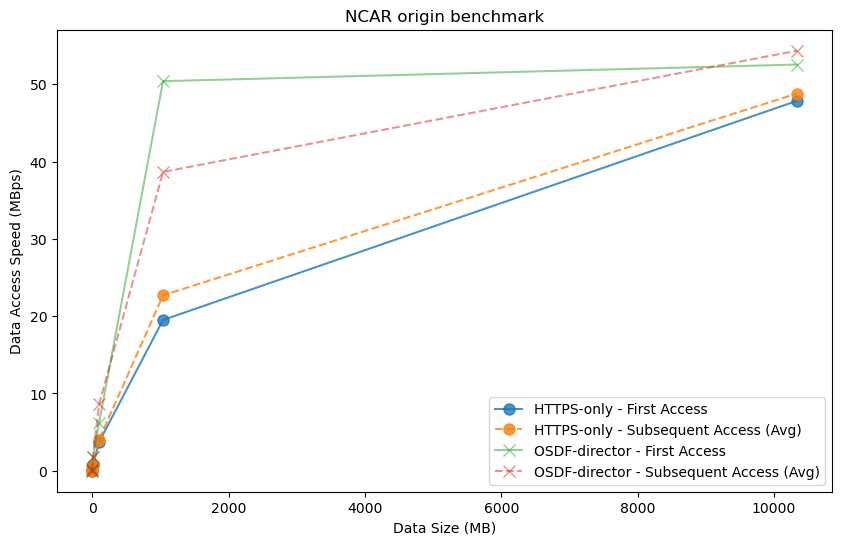

In [25]:
# Plotting MBps vs data size for each protocol and call type
# Define different alpha values for each protocol
alpha_values = {"HTTPS-only": 0.8, "OSDF-director": 0.5}  # Adjust transparency as needed
marker_style = {"HTTPS-only": "o", "OSDF-director": "x"}  # Define different markers for each protocol
#
fig, ax = plt.subplots(figsize=(10, 6))
for protocol in ["HTTPS-only", "OSDF-director"]:
    # First access (call_number == 1)
    first_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] == 1)]
    ax.plot(first_access['dataset_size'], first_access['MBps'], label=f"{protocol} - First Access",
            alpha=alpha_values[protocol],marker=marker_style[protocol],markersize=8)

    # Subsequent access (call_number > 1)
    subsequent_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] > 1)]
    subsequent_access_avg = subsequent_access.groupby('dataset_size')['MBps'].mean()
    ax.plot(subsequent_access_avg.index, subsequent_access_avg.values, 
            linestyle='--', label=f"{protocol} - Subsequent Access (Avg)",alpha=alpha_values[protocol],marker=marker_style[protocol],markersize=8)
    
# Customize plot appearance
ax.set_xlabel("Data Size (MB)")
ax.set_ylabel("Data Access Speed (MBps)")
ax.set_title("NCAR origin benchmark")
ax.legend()
plt.show()


### Try with a specific cache

In [26]:
# historical_smbb_test1 = historical_smbb.isel(time=0).isel(member_id =1+ np.arange(5))
# historical_smbb_test1

In [27]:
# %%timeit -r2 -n3 -o
# historical_smbb_test1.compute()

In [28]:
# #Try using a specific cache
# sdsc_cache='https://sdsc-cache.nationalresearchplatform.org:8443/aws-opendata/us-west-2/ncar-cesm2-lens/atm/monthly/'+\
#             'cesm2LE-historical-smbb-TREFHTMX.zarr'

In [29]:
# %%time
# test_1 = xr.open_zarr(sdsc_cache).TREFHTMX.isel(time=0)
# test_1